In [98]:
from itertools import islice

import networkx as nx
import numpy as np

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN

In [99]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.dataset = "CPG_pmart"
args.pattern_dataset = "CPG_all"
#args.pattern_dataset = "CPG_pmart"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [100]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_undirected_anchored_v1/model.pt ...


In [101]:
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False )
up_sources = dataset.get_sources()
up_patterns = dataset.get_patterns()

Loading sources from CPG_pmart ...


100%|██████████| 1473/1473 [00:00<00:00, 3648.40it/s]


Loading sources from CPG_all ...


100%|██████████| 22072/22072 [00:06<00:00, 3409.58it/s]


In [102]:
p_sources = up_sources
p_sources = epm.filter_sources( p_sources, dataset.get_source_patterns(), max_sources_per_pattern=10 )
p_sources = epm.normalize_sources( p_sources, max_distance=7 )

p_patterns = up_patterns
#p_patterns = epm.normalize_patterns( p_patterns, max_distance=8 )
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=20, n_decay=4 )
"""
p_patterns = epm.normalize_patterns_by_presence( p_patterns,
                                                 num_graphs=4, max_distance=6,
                                                 n_start=30, n_decay=2 )
"""
dataset.set_sources( p_sources )
dataset.set_patterns( p_patterns )
dataset.compute_samples()

Filtering sources ...


100%|██████████| 1473/1473 [00:00<00:00, 4335585.82it/s]


Normalizing sources ...


100%|██████████| 58/58 [00:00<00:00, 67.99it/s] 


Normalizing patterns to connected ...


100%|██████████| 7/7 [00:00<00:00, 57.52it/s]


Filter connected patterns by presence ...


100%|██████████| 7/7 [00:00<00:00, 17149.61it/s]


In [103]:
source_pattern_counts = { }
for gidx, pattern in dataset.get_source_patterns().items():
    if gidx not in dataset.get_sources():
        continue
    if pattern not in source_pattern_counts:
        source_pattern_counts[ pattern ] = 0
    source_pattern_counts[ pattern ] += 1
print( "source_pattern_counts:", misc_utils.sort_dict_by_key( source_pattern_counts ) )

pattern_example_counts = { dp: len( l ) for dp, l in dataset.get_patterns().items() }
print( "pattern_example_counts:", misc_utils.sort_dict_by_key( pattern_example_counts ) )

source_pattern_counts: {'ADAPTER': 10, 'BUILDER': 10, 'FACADE': 1, 'FACTORY_METHOD': 10, 'N/A': 10, 'OBSERVER': 10, 'SINGLETON': 7}
pattern_example_counts: {'ABSTRACT_FACTORY': 4, 'ADAPTER': 4, 'BUILDER': 4, 'FACADE': 4, 'FACTORY_METHOD': 4, 'OBSERVER': 4, 'SINGLETON': 4}


In [104]:
def sample_processor_path_match_weighted( source: nx.Graph, query: nx.Graph, meta: dict ) -> tuple[ list, list, list ]:
    source_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( source ) ] )
    query_paths = set( [ path[ 1 ] for path in graph_utils.get_all_norm_paths( query ) ] )
    max_match = 0
    for sp in source_paths:
        for qp in query_paths:
            for k in list( range( 1, min( len( sp ), len( qp ) ) + 1 ) ):
                qpk = qp[ :k ]
                if sp.startswith( qpk ) and len( qpk ) > max_match:
                    max_match = len( qpk )

    pred_w = max_match / max( [ len( p ) for p in source_paths ] )
    _meta = meta.copy()
    _meta[ "pred_w" ] = pred_w
    return epm.sample_processor_default( source, query, _meta )

In [105]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                #sample_processor=epm.sample_processor_subgraph_normalized,
                                                sample_processor=epm.sample_processor_k_normalized,
                                                min_d_offset=1, max_d_offset=5,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 13/13 [00:02<00:00,  5.88it/s]

source: 3389 / queries: 3389
preds: 3389 / metas: 3389
meta example: {'source_type': 'N/A', 'pattern_type': 'FACTORY_METHOD', 'gidx': 1461, 'record_scope': 'net.nutch.io.DataOutputBuffer', 'pred_w': 0.65}


In [106]:
def aggregate_preds_max( preds: list[ float ] ) -> float:
    return float( np.max( preds ) )

In [156]:
def compute_labels( source_types: dict[ int, str ],
                          source_preds: dict[ int, dict[ str, float ] ],
                          conf=0.5 ) -> tuple[ list[ str ], list[ str ], list[ float ] ]:
    true_labels = [ ]
    pred_labels = [ ]
    pred_scores = [ ]
    for gidx, source_type in source_types.items():
        source_pattern_preds = source_preds[ gidx ]
        source_pred_type = cpg_const.NO_DESIGN_PATTERN
        source_pred_score = 0.0
        for dp_type, dp_pred in source_pattern_preds.items():
            if dp_pred > conf:
                if dp_pred > source_pred_score:
                    source_pred_score = dp_pred
                    source_pred_type = dp_type
                if source_type == dp_type:
                    source_pred_type = dp_type
                    source_pred_score = dp_pred
                    break

        true_labels.append( source_type )
        pred_labels.append( source_pred_type )
        pred_scores.append( source_pred_score )

    return true_labels, pred_labels, pred_scores


In [175]:
groups_by_source = epm.group_by_source( metas )
source_preds = epm.compute_source_preds( groups_by_source, preds, metas,
                                         #pred_aggregator=epm.aggregate_preds_mean )
                                         #pred_aggregator=aggregate_preds_max )
                                         pred_aggregator=epm.aggregate_preds_by_quantile, q=0.99 )
source_types = epm.compute_source_types( metas )
#true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds, conf=0.5, top_k=1 )
true_labels, pred_labels, pred_scores = compute_labels( source_types, source_preds, conf=0.4 )

for k, v in islice( source_types.items(), 3 ):
    print( f"type::{k}={source_types[ k ]}" )
    print( f"group::{k}={groups_by_source[ k ]}" )
    print( f"pred::{k}={source_preds[ k ]}\n" )

type::1461=N/A
group::1461={'FACTORY_METHOD': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'OBSERVER': [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], 'ADAPTER': [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], 'BUILDER': [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], 'FACADE': [44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], 'SINGLETON': [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], 'ABSTRACT_FACTORY': [66, 67, 68, 69, 70, 71, 72]}
pred::1461={'FACTORY_METHOD': 0.38984014280140405, 'OBSERVER': 0.7938167630881072, 'ADAPTER': 0.7928830456733704, 'BUILDER': 0.6203371113538743, 'FACADE': 0.622930898666382, 'SINGLETON': 0.6185185682773592, 'ABSTRACT_FACTORY': 0.2800263921916485}

type::1423=N/A
group::1423={'FACTORY_METHOD': [73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], 'OBSERVER': [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], 'ADAPTER': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105], 'BUILDER': [106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116], 'FACADE': [117, 118, 119, 120, 121, 122, 123, 124, 1

In [176]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.78] Acc=[0.603] Prec=[0.736] Rec=[0.603] F1=[0.659] AvgPrec=[0.566]


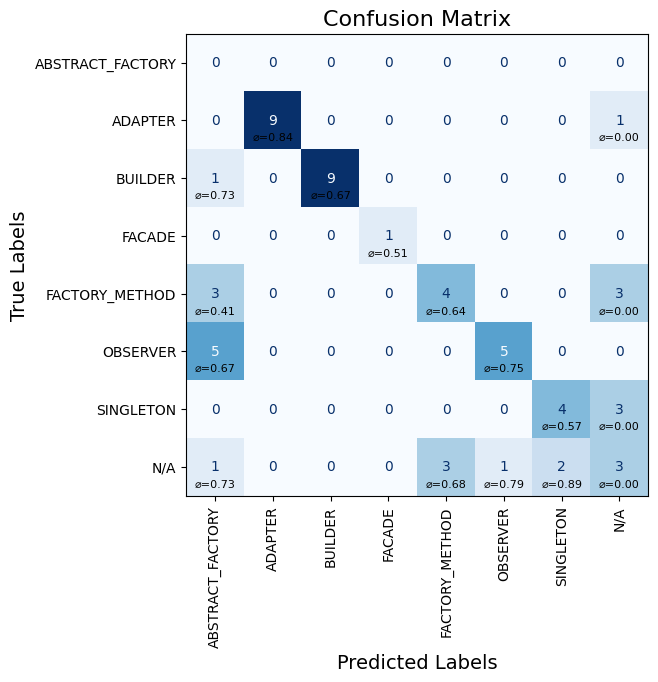

In [177]:
epm.compute_cm( true_labels, pred_labels, pred_scores )

Should be: OBSERVER
ADAPTER: 0.809
OBSERVER: 0.606
BUILDER: 0.602
SINGLETON: 0.597
FACTORY_METHOD: 0.433
FACADE: 0.425
ABSTRACT_FACTORY: 0.396
{'source_type': 'OBSERVER', 'pattern_type': 'FACTORY_METHOD', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


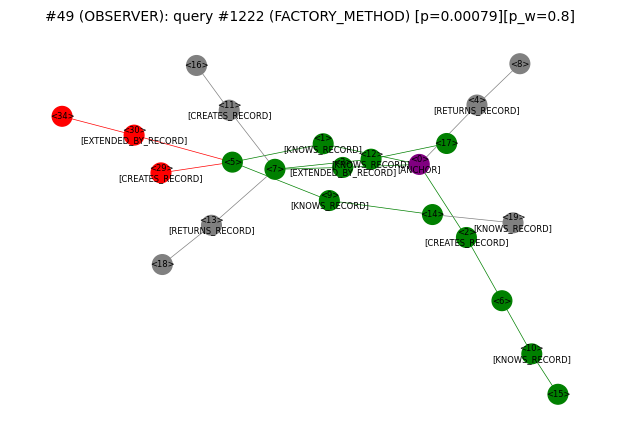

{'source_type': 'OBSERVER', 'pattern_type': 'OBSERVER', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


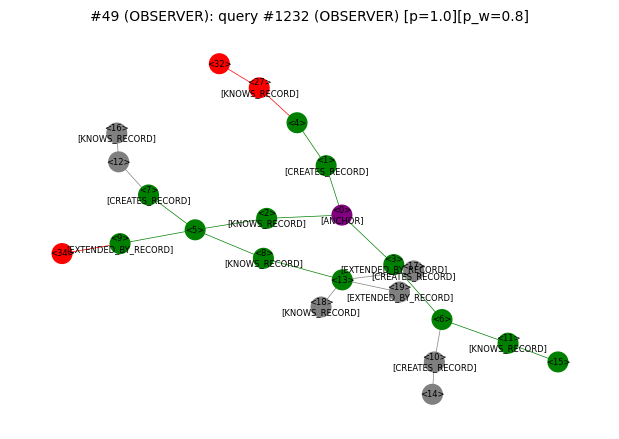

{'source_type': 'OBSERVER', 'pattern_type': 'ADAPTER', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


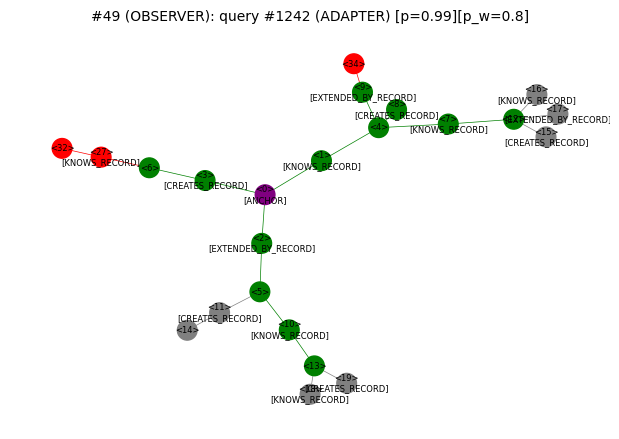

{'source_type': 'OBSERVER', 'pattern_type': 'BUILDER', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


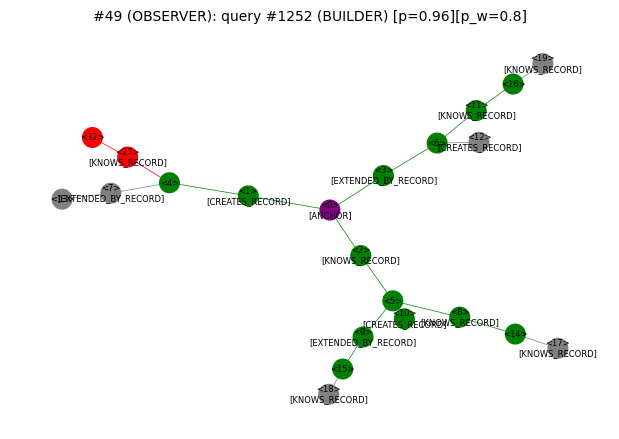

{'source_type': 'OBSERVER', 'pattern_type': 'FACADE', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


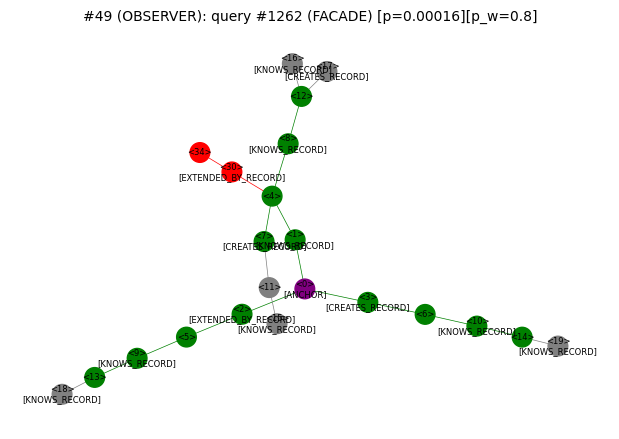

{'source_type': 'OBSERVER', 'pattern_type': 'SINGLETON', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.8}


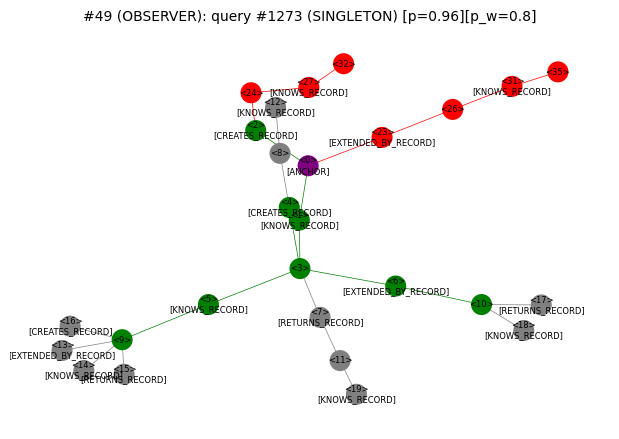

{'source_type': 'OBSERVER', 'pattern_type': 'ABSTRACT_FACTORY', 'gidx': 49, 'record_scope': 'junit.swingui.TestSuitePanel', 'pred_w': 0.6}


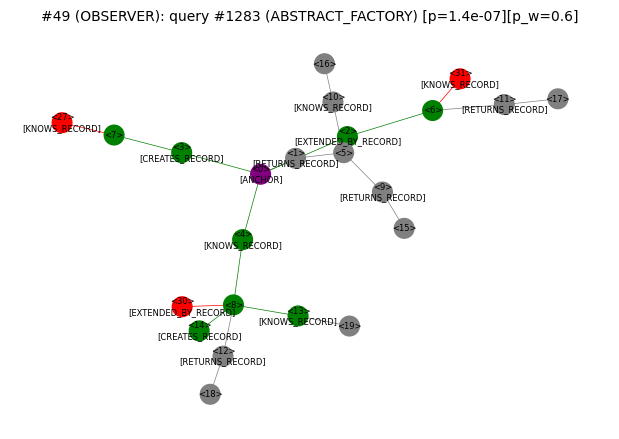

In [111]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = -1
source_iter = iter( groups_by_source )
for _ in range( 21 ):
    example_gidx = next( source_iter )
print( f"Should be: {dataset.get_source_patterns()[ example_gidx ]}" )
for pattern_type, score in misc_utils.sort_dict_by_value(
        source_preds[ example_gidx ], reverse=True ).items():
    print( f"{pattern_type}: {score:.3}" )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        pred = preds[ idx ]
        meta = metas[ idx ]
        print( meta )
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )